# Сегментация изображений подводных сцен

В этом домашнем задании вам предстоит обучить нейросеть для сегментации подводных сцен.

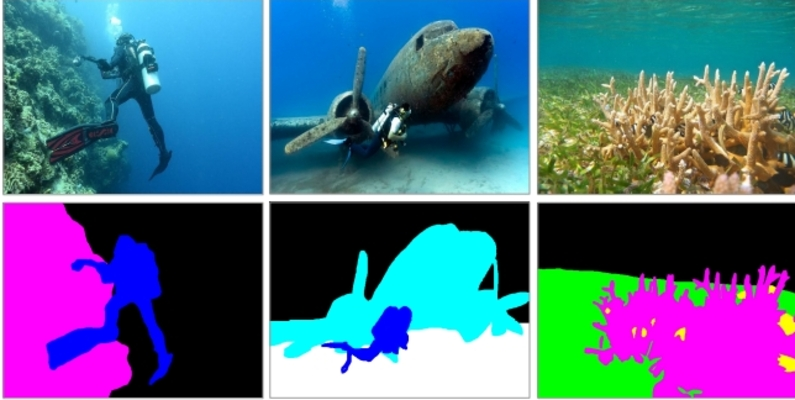

## Подготовка датасета

#### Скачивание данных

Ячейки ниже скачивают и распаковывают данные

In [1]:
! pip install wldhx.yadisk-direct

In [2]:
! curl -L $(yadisk-direct https://disk.yandex.com/d/-93qaZ4NbYmwug) -o underwater_data.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  174M  100  174M    0     0  49.0M      0  0:00:03  0:00:03 --:--:-- 71.7M


In [3]:
! unzip -qq underwater_data.zip

#### Загрузка датасета

Давайте поймем, как устроен наш датасет. Откроем несколько картинок и посмотрим на них.

In [ ]:
import numpy as np
import pandas as pd
from PIL import Image
import os
import matplotlib.pyplot as plt
import cv2

from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

В папке underwater_data содержится две подпапки: train и test. В папке train лежат обучающие картинки (train/images) и их карты сегментации (train/masks). В папке test находятся картинки тестовой выборки, к которым карт сегментации нет. Ваша задача — обучить нейросеть на данных из train и получить предсказания для test. Эти предсказания нужно будет отправить в Я.Контест в качестве решения.

Классов сегментации всего 8:
- рыбы;
- рифы;
- морские растения;
- скалы/камни;
- дайверы (человеки);
- роботы;
- дно океана;
- все остальное (фон).

Откроем несколько картинок:

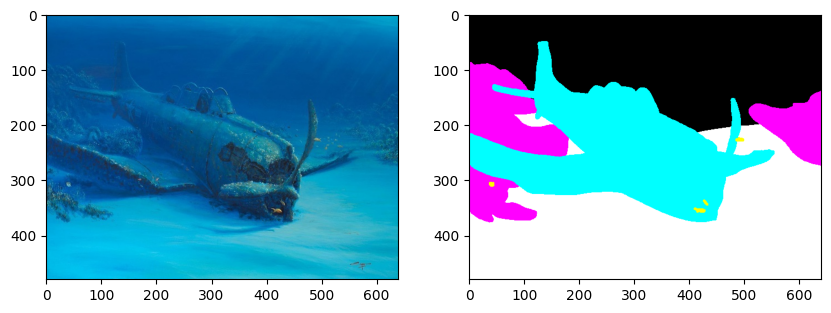

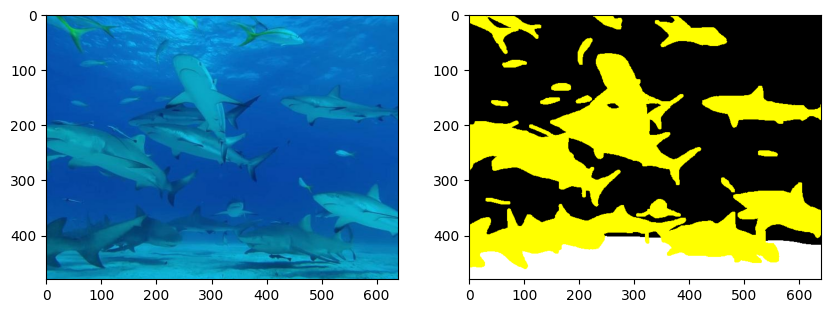

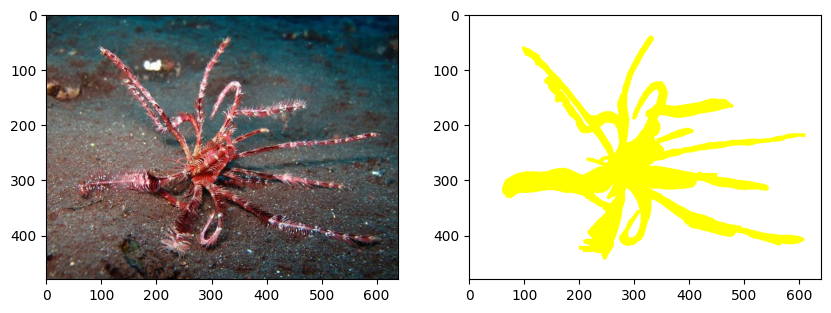

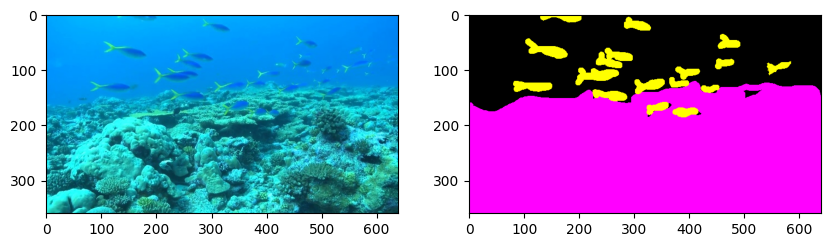

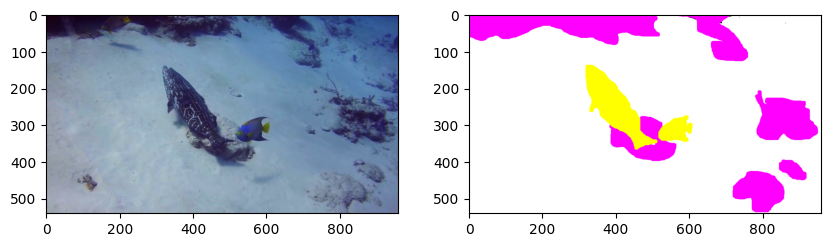

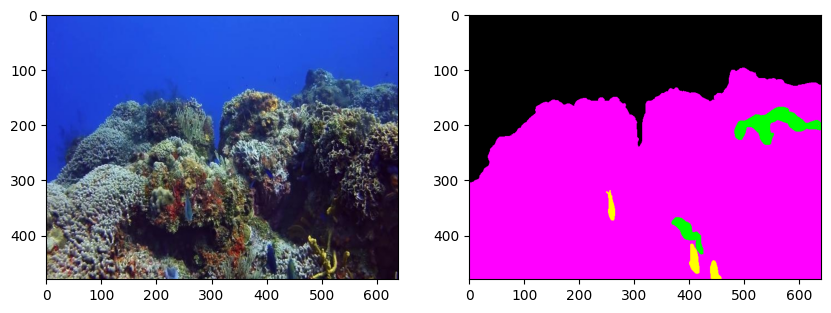

In [ ]:
img_names = os.listdir('./underwater_data/train/images/')

for i, img_name in enumerate(img_names[:6]):
    # считываем картинку и ее карту сегментации
    img = plt.imread('./underwater_data/train/images/'+ img_name)
    img_seg = plt.imread('./underwater_data/train/masks/'+ img_name[:-4]+'.bmp')

    # отрисовываем две картинки рядом друг с другом

    plt.figure(figsize=(10,8))

    plt.subplot(1,2,1)
    plt.imshow(img)

    plt.subplot(1,2,2)
    plt.imshow(img_seg)

Посмотрим, как устроена картинка-карта сегментации:

array([[[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[255,   0, 255],
        [255,   0, 255],
        [255,   0, 255],
        ...,
        [255,   0, 255],
        [255,   0, 255],
        [255,   0, 255]],

       [[255,   0, 255],
        [255,   0, 255],
        [255,   0, 255],
        ...,
        [255,   0, 255],
        [255,   0, 255],
        [255,   0, 255]],

       [[255,   0, 255],
        [255,   0, 255],
        [255,   0, 255],
        ...,
        [255,   0, 255],
        [255,   0, 255],
        [255,   0, 255]]], dtype=uint8)
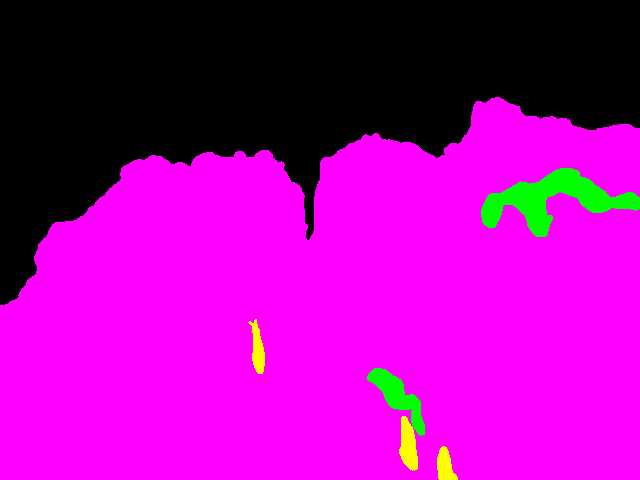

In [ ]:
img_seg

Как видим, в этот раз карты сегментации — это RGB-картинки. Пиксели разных классов имеют вид [0, 255, 255], [255 ,0, 0] и т.д.

Чтобы обучить нейросеть, нам нужно перевести карты сегментации в привычный вид — двумерный, где каждый пиксель имеет значение от 0 до 7 (т.е. значение пиксел я — это номер его класса). Сделать это нам поможет следующая функция:

In [ ]:
def preprocess_mask(mask):
    mask = (mask > 100)
    mask = np.dot(mask, [4,2,1]).astype(np.uint8)
    return mask

Применим функцию к одной маске сегментации:

array([[5, 5, 5, ..., 5, 5, 5],
       [5, 5, 5, ..., 5, 5, 5],
       [5, 5, 5, ..., 5, 5, 5],
       ...,
       [7, 7, 7, ..., 5, 5, 5],
       [7, 7, 7, ..., 5, 5, 5],
       [7, 7, 7, ..., 5, 5, 5]], dtype=uint8)
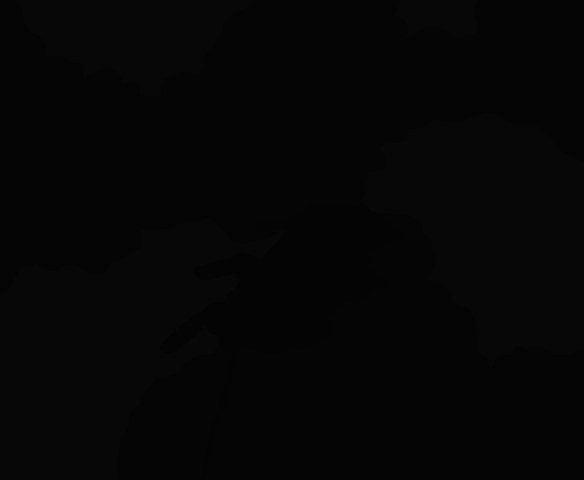

In [ ]:
img_seg = plt.imread('./underwater_data/train/masks/d_r_1_.bmp')
new_img_seg = preprocess_mask(img_seg)
new_img_seg

Как видим, все полуичлось! На всякий случай выведем новую маску сегментации, чтобы убедиться, что она не сломалась:

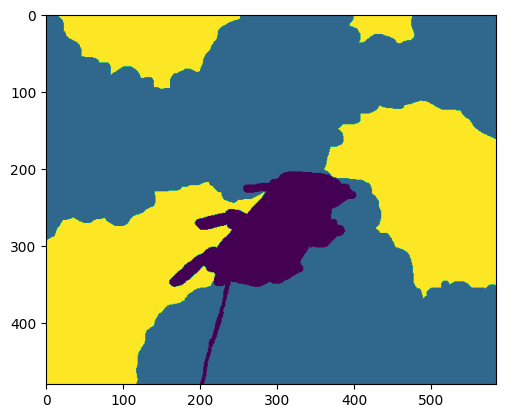

In [ ]:
plt.imshow(new_img_seg)

Теперь можно переходить к созданию датасета.

#### Создание Dataset

Для начала создадим два списка:
- список с путями до RGB картинок;
- список с путями до карт сегментаций этих картинок;

In [ ]:
images = []
segmentation_masks = []

for img_name in os.listdir('./underwater_data/train/images/'):
    images.append('./underwater_data/train/images/' + img_name)
    segmentation_masks.append('underwater_data/train/masks/' + img_name[:-4]+'.bmp')

In [ ]:
images[:5], segmentation_masks[:5]

(['./underwater_data/train/images/w_r_134_.jpg',
  './underwater_data/train/images/f_r_1730_.jpg',
  './underwater_data/train/images/f_r_2005_.jpg',
  './underwater_data/train/images/f_r_672_.jpg',
  './underwater_data/train/images/n_l_77_.jpg'],
 ['underwater_data/train/masks/w_r_134_.bmp',
  'underwater_data/train/masks/f_r_1730_.bmp',
  'underwater_data/train/masks/f_r_2005_.bmp',
  'underwater_data/train/masks/f_r_672_.bmp',
  'underwater_data/train/masks/n_l_77_.bmp'])

Теперь создадим кастомный датасет torch.utils.data.Dataset для удобной работы c нашими данными в PyTorch.

In [ ]:
class UnderwaterDataset(Dataset):
    def __init__(self, images, segmentation_masks):

        self.images = images
        self.segmentation_masks = segmentation_masks

        self.images_transforms = transforms.Compose([
            transforms.Resize((128, 128)), # размер каждой картинки будет приведен к 256*256
            transforms.ToTensor(), # картинка из питоновского массива переводится в формат torch.Tensor
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]) # значения пикселей картинки нормализуются
        ])

        self.masks_transforms = transforms.Compose([
            # используем InterpolationMode.NEAREST, чтобы при изменении размера
            # маски сегментации не менялись номера классов
            transforms.Resize((128, 128), interpolation=transforms.InterpolationMode.NEAREST), # размер каждой картинки будет приведен к 256*256
            transforms.ToTensor(), # картинка из питоновского массива переводится в формат torch.Tensor
        ])

    def preprocess_mask(self, mask):
        mask = (np.array(mask) > 100)
        mask = np.dot(mask, [4,2,1]).astype(np.uint8)
        return Image.fromarray(mask)

    def __getitem__(self, index):
        '''
        этот метод должен по заданному номеру пары картинка-сегментация (index)
        возвращать эту пару. Этот метод обязательно нужно реализовывать во всех
        кастомных классах Dataset. Перед тем, как выдать на выходе
        пару картинка-сегментация, можно применить к картинкам любые преобразования:
        например, знакомую нам аугментацию.
        '''

        # загружаем нужные картинку и ее карту сегментации
        img = Image.open(self.images[index])
        mask = Image.open(self.segmentation_masks[index])

        # # применяем предобработку к RGB картинке
        img = self.images_transforms(img)
        # # применяем предобработку к маске сегментации
        mask = self.masks_transforms(self.preprocess_mask(mask))

        return (img, mask.squeeze()*255)

    def __len__(self):
        '''
        этот метод должен возвращать количество пар картинка-сегментация в датасете
        '''
        return len(self.images)

Проверим, что наш Dataset работает. Заведем переменную датасета и возьмем нулевой элемент. Отрисуем картинку и ее карту сегментации.

torch.Size([3, 128, 128]) torch.Size([128, 128])


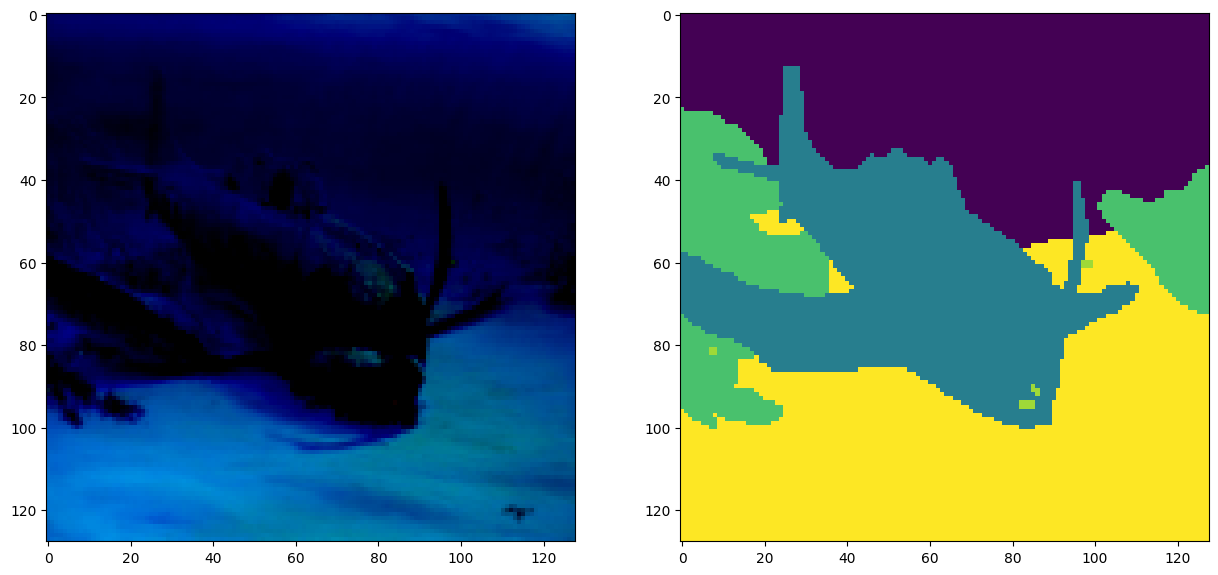

In [ ]:
dataset = UnderwaterDataset(images, segmentation_masks)

# dataset[0] — это вызов метода __getitem__(0)
img, mask = dataset[0]

print(img.shape, mask.shape)

# отрисовываем картинку
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].imshow(img.permute(1, 2, 0))
# отрисовываем маску
ax[1].imshow(mask.squeeze())
plt.show()

Готово! Разделим выборку на train и val:

In [ ]:
train_size = int(len(dataset) * 0.8)
val_size = len(dataset) - train_size

train_data, val_data = torch.utils.data.random_split(dataset, [train_size, val_size])

И заведем даталоадеры:

In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=32, shuffle=False)

## Создание модели

Ваша задача — объявить и обучить модель, используя тренировочные и валидационные данные. Затем нужно получить предсказание на тестовых данных и отправить их в Я.Контест.

Ваши посылки будут оцениваться по метрике mIoU. Баллы будут ставиться следующим образом:
- 0 баллов, если mIoU < 0.4;
- 5 баллов, если 0.4 < mIoU < 0.5;
- 7.5 баллов, если 0.5 < mIoU < 0.6;
- 10 баллов, если mIoU > 0.6;

Какие идеи можно попробовать, чтобы получить больший скор:
- Обучить с нуля SegNet, UNet;
- Дообучить предобученную модель. Предобученные модели для сегментации можно использовать из библиотеки [segmentation_models_pytorch](https://github.com/qubvel/segmentation_models.pytorch)
- Для более эффективного обучения вам может пригодиться LR Scheduler для автоматической настройки learning rate в процесее обучения. [Вот тут](https://www.kaggle.com/code/isbhargav/guide-to-pytorch-learning-rate-scheduling) можно подробнее узнать про виды LR Scheduler и как использовать его в PyTorch
- Попробовать Dice Loss вместо CE;
- Аугментация данных. Обратите внимание, что мы решаем задачу сегментации, и если вы делаете с входящими картинками преобразования, которые меняют положение пикселей (shift/поворот/рястяжение и т.п.), то такое же преобразование нужно сделать и с соответствующей картой сегментации;
- Другие идеи, которые могут прийти вам в голову или можно найти в интернете =)

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()

        if not mid_channels:
            mid_channels = out_channels

        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [ ]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()

        self.n_channels = n_channels
        self.n_classese = n_classes

        self.in_conv = DoubleConv(n_channels, 64)

        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)

        self.up4 = Up(1024, 512)
        self.up3 = Up(512, 256)
        self.up2 = Up(256, 128)
        self.up1 = Up(128, 64)

        self.out_conv = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.in_conv(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        x = self.up4(x5, x4)
        x = self.up3(x, x3)
        x = self.up2(x, x2)
        x = self.up1(x, x1)

        logits = self.out_conv(x)
        return logits


In [ ]:
unet_model = UNet(3, 1)

Ниже дан код, который может вам пригодиться для оценки качества вашей сети во время обучения:
- функция pixel_accuracy считает попиксельный accuracy между output (выход сети) и mask (верная карта сегментации);
- функция mIoU считает средний IoU по всем классам сегментации между output (выход сети) и mask (верная карта сегментации);

In [ ]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

def mIoU(pred_mask, mask, smooth=1e-10, n_classes=8):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes):
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0:
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [ ]:
from tqdm import tqdm
import torch.nn.functional as F
import torch.optim as optim

unet_model = UNet(3, 8) # 3, 8
unet_model = unet_model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(unet_model.parameters(), lr=0.001)

In [ ]:
checkpoint = torch.load('checkpoint.pth')
unet_model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
loss = checkpoint.get('loss', None)

In [ ]:
def get_predictions_and_metrics(model, dataloader, n_classes):
    model.eval()
    pixel_accs = []
    mious = []

    with torch.no_grad():
        for img, mask in tqdm(dataloader):
            img, mask = img.to(device), mask.to(device)  # Если используется GPU
            pred = model(img)

            acc = pixel_accuracy(pred, mask)
            miou = mIoU(pred, mask, n_classes=n_classes)

            pixel_accs.append(acc)
            mious.append(miou)

    model.train()
    avg_pixel_acc = np.mean(pixel_accs)
    avg_miou = np.mean(mious)

    return avg_pixel_acc, avg_miou

epochs = 500
for epoch in range(epochs):
    unet_model.train()
    total_loss = 0
    for img, mask in tqdm(train_loader):
        img, mask = img.to(device), mask.to(device)  # Если используется GPU
        optimizer.zero_grad()

        pred = unet_model(img)
        mask = mask.long()
        loss = loss_fn(pred, mask)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss}')

    if epoch % 100 == 0:
        model_state_dict = unet_model.state_dict()
        optimizer_state_dict = optimizer.state_dict()

        checkpoint = {
            'model_state_dict': model_state_dict,
            'optimizer_state_dict': optimizer_state_dict,
            'loss': loss
        }

        torch.save(checkpoint, 'checkpoint.pth')

    # Вычисление метрик после каждой эпохи
    avg_pixel_acc, avg_miou = get_predictions_and_metrics(unet_model, val_loader, n_classes=8)
    print(f'Validation Pixel Accuracy: {avg_pixel_acc}')
    print(f'Validation mIoU: {avg_miou}')

 97%|█████████▋| 38/39 [00:36<00:00,  1.27it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 39/39 [00:36<00:00,  1.06it/s]


Epoch 1/500, Loss: 1.4352564200376854


100%|██████████| 10/10 [00:04<00:00,  2.13it/s]


Validation Pixel Accuracy: 0.5711237963508158
Validation mIoU: 0.1502052549727419


100%|██████████| 39/39 [00:30<00:00,  1.26it/s]


Epoch 2/500, Loss: 1.2305601896383824


100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


Validation Pixel Accuracy: 0.6137460933012121
Validation mIoU: 0.17233647054348117


100%|██████████| 39/39 [00:31<00:00,  1.24it/s]


Epoch 3/500, Loss: 1.1657043603750377


100%|██████████| 10/10 [00:04<00:00,  2.01it/s]


Validation Pixel Accuracy: 0.6180053598740521
Validation mIoU: 0.19786284099855925


100%|██████████| 39/39 [00:31<00:00,  1.26it/s]


Epoch 4/500, Loss: 1.1305698095223842


100%|██████████| 10/10 [00:05<00:00,  1.84it/s]


Validation Pixel Accuracy: 0.6113038119147806
Validation mIoU: 0.20008403134661132


100%|██████████| 39/39 [00:30<00:00,  1.29it/s]


Epoch 5/500, Loss: 1.0996529750334911


100%|██████████| 10/10 [00:05<00:00,  1.86it/s]


Validation Pixel Accuracy: 0.643510560428395
Validation mIoU: 0.2375245911757856


100%|██████████| 39/39 [00:30<00:00,  1.29it/s]


Epoch 6/500, Loss: 1.072771043349535


100%|██████████| 10/10 [00:04<00:00,  2.21it/s]


Validation Pixel Accuracy: 0.6319528243120979
Validation mIoU: 0.2377550867108101


100%|██████████| 39/39 [00:30<00:00,  1.26it/s]


Epoch 7/500, Loss: 1.0476401983163295


100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


Validation Pixel Accuracy: 0.6155301374547621
Validation mIoU: 0.22545934559402933


100%|██████████| 39/39 [00:30<00:00,  1.27it/s]


Epoch 8/500, Loss: 1.0676664144564898


100%|██████████| 10/10 [00:04<00:00,  2.20it/s]


Validation Pixel Accuracy: 0.6263511657714844
Validation mIoU: 0.2314071331835122


100%|██████████| 39/39 [00:30<00:00,  1.30it/s]


Epoch 9/500, Loss: 1.0612871631597862


100%|██████████| 10/10 [00:05<00:00,  1.85it/s]


Validation Pixel Accuracy: 0.6090524224674001
Validation mIoU: 0.230361283978796


100%|██████████| 39/39 [00:30<00:00,  1.29it/s]


Epoch 10/500, Loss: 1.0598399257048583


100%|██████████| 10/10 [00:05<00:00,  1.85it/s]


Validation Pixel Accuracy: 0.6498462564804974
Validation mIoU: 0.23765076886313272


100%|██████████| 39/39 [00:30<00:00,  1.26it/s]


Epoch 11/500, Loss: 1.0188920666009953


100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


Validation Pixel Accuracy: 0.6460444843067842
Validation mIoU: 0.2454488534904545


100%|██████████| 39/39 [00:30<00:00,  1.27it/s]


Epoch 12/500, Loss: 1.0073108321581132


100%|██████████| 10/10 [00:04<00:00,  2.20it/s]


Validation Pixel Accuracy: 0.6431963415706858
Validation mIoU: 0.23359134821012995


100%|██████████| 39/39 [00:30<00:00,  1.27it/s]


Epoch 13/500, Loss: 1.0193192928265302


100%|██████████| 10/10 [00:04<00:00,  2.20it/s]


Validation Pixel Accuracy: 0.6628000932581284
Validation mIoU: 0.25918494792187013


100%|██████████| 39/39 [00:30<00:00,  1.29it/s]


Epoch 14/500, Loss: 0.9883390879019712


100%|██████████| 10/10 [00:05<00:00,  1.91it/s]


Validation Pixel Accuracy: 0.6456038194544175
Validation mIoU: 0.25334070486786514


100%|██████████| 39/39 [00:30<00:00,  1.29it/s]


Epoch 15/500, Loss: 0.9793800253134507


100%|██████████| 10/10 [00:05<00:00,  1.86it/s]


Validation Pixel Accuracy: 0.6536055508781882
Validation mIoU: 0.25141523886711836


100%|██████████| 39/39 [00:30<00:00,  1.29it/s]


Epoch 16/500, Loss: 0.9897393782933553


100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


Validation Pixel Accuracy: 0.6416403265560374
Validation mIoU: 0.23926600176542964


100%|██████████| 39/39 [00:30<00:00,  1.27it/s]


Epoch 17/500, Loss: 0.9514997081878858


100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


Validation Pixel Accuracy: 0.6690192054299747
Validation mIoU: 0.26667421389772084


100%|██████████| 39/39 [00:31<00:00,  1.25it/s]


Epoch 18/500, Loss: 0.9395424723625183


100%|██████████| 10/10 [00:05<00:00,  1.92it/s]


Validation Pixel Accuracy: 0.6430719712201287
Validation mIoU: 0.24792081796022808


100%|██████████| 39/39 [00:30<00:00,  1.26it/s]


Epoch 19/500, Loss: 0.9530111367885883


100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


Validation Pixel Accuracy: 0.6680165683521944
Validation mIoU: 0.2745635027544944


100%|██████████| 39/39 [00:30<00:00,  1.28it/s]


Epoch 20/500, Loss: 0.9325544681304541


100%|██████████| 10/10 [00:05<00:00,  1.91it/s]


Validation Pixel Accuracy: 0.5888255063225241
Validation mIoU: 0.23194585906852985


100%|██████████| 39/39 [00:30<00:00,  1.28it/s]


Epoch 21/500, Loss: 0.9198874632517496


100%|██████████| 10/10 [00:05<00:00,  1.88it/s]


Validation Pixel Accuracy: 0.6831596935496611
Validation mIoU: 0.284316465761708


100%|██████████| 39/39 [00:30<00:00,  1.29it/s]


Epoch 22/500, Loss: 0.9191373311556302


100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


Validation Pixel Accuracy: 0.6599151947919061
Validation mIoU: 0.2739911190402114


100%|██████████| 39/39 [00:30<00:00,  1.27it/s]


Epoch 23/500, Loss: 0.9086152758353796


100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


Validation Pixel Accuracy: 0.6017247929292566
Validation mIoU: 0.24168643655694258


100%|██████████| 39/39 [00:30<00:00,  1.27it/s]


Epoch 24/500, Loss: 0.9474779474429595


100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


Validation Pixel Accuracy: 0.6760900160845588
Validation mIoU: 0.2850036406767235


100%|██████████| 39/39 [00:30<00:00,  1.26it/s]


Epoch 25/500, Loss: 0.884422976237077


100%|██████████| 10/10 [00:04<00:00,  2.13it/s]


Validation Pixel Accuracy: 0.6773279751048369
Validation mIoU: 0.26656458239562303


100%|██████████| 39/39 [00:30<00:00,  1.27it/s]


Epoch 26/500, Loss: 0.8636621007552514


100%|██████████| 10/10 [00:05<00:00,  1.84it/s]


Validation Pixel Accuracy: 0.6752049390007467
Validation mIoU: 0.2889004001963942


100%|██████████| 39/39 [00:30<00:00,  1.29it/s]


Epoch 27/500, Loss: 0.8552749768281595


100%|██████████| 10/10 [00:05<00:00,  1.86it/s]


Validation Pixel Accuracy: 0.6976672677432789
Validation mIoU: 0.30397422203367147


100%|██████████| 39/39 [00:30<00:00,  1.28it/s]


Epoch 28/500, Loss: 0.8556895806239202


100%|██████████| 10/10 [00:04<00:00,  2.07it/s]


Validation Pixel Accuracy: 0.6689179476569681
Validation mIoU: 0.2965779992632939


100%|██████████| 39/39 [00:30<00:00,  1.27it/s]


Epoch 29/500, Loss: 0.8534719867584033


100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


Validation Pixel Accuracy: 0.671484229143928
Validation mIoU: 0.30937425628091


100%|██████████| 39/39 [00:30<00:00,  1.26it/s]


Epoch 30/500, Loss: 0.8550546612495031


100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


Validation Pixel Accuracy: 0.7046894746668199
Validation mIoU: 0.3055860960822132


100%|██████████| 39/39 [00:30<00:00,  1.28it/s]


Epoch 31/500, Loss: 0.8345314340713696


100%|██████████| 10/10 [00:04<00:00,  2.02it/s]


Validation Pixel Accuracy: 0.6729468177346623
Validation mIoU: 0.28309733252486957


100%|██████████| 39/39 [00:30<00:00,  1.29it/s]


Epoch 32/500, Loss: 0.8066613460198427


100%|██████████| 10/10 [00:05<00:00,  1.86it/s]


Validation Pixel Accuracy: 0.6998821146347943
Validation mIoU: 0.3113034300123212


100%|██████████| 39/39 [00:31<00:00,  1.26it/s]


Epoch 33/500, Loss: 0.8399499501937475


100%|██████████| 10/10 [00:06<00:00,  1.66it/s]


Validation Pixel Accuracy: 0.6617997674381032
Validation mIoU: 0.29377457423036074


100%|██████████| 39/39 [00:30<00:00,  1.26it/s]


Epoch 34/500, Loss: 0.8153582765505865


100%|██████████| 10/10 [00:04<00:00,  2.20it/s]


Validation Pixel Accuracy: 0.7038651185877183
Validation mIoU: 0.3173394231425997


100%|██████████| 39/39 [00:30<00:00,  1.27it/s]


Epoch 35/500, Loss: 0.806840656659542


100%|██████████| 10/10 [00:04<00:00,  2.20it/s]


Validation Pixel Accuracy: 0.7115036235136144
Validation mIoU: 0.32828135763927196


100%|██████████| 39/39 [00:30<00:00,  1.28it/s]


Epoch 36/500, Loss: 0.7737124806795365


100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


Validation Pixel Accuracy: 0.6971500957713408
Validation mIoU: 0.3145189303211849


100%|██████████| 39/39 [00:30<00:00,  1.29it/s]


Epoch 37/500, Loss: 0.793638024574671


100%|██████████| 10/10 [00:05<00:00,  1.85it/s]


Validation Pixel Accuracy: 0.6915373297298656
Validation mIoU: 0.28528242519664604


100%|██████████| 39/39 [00:30<00:00,  1.29it/s]


Epoch 38/500, Loss: 0.794599847915845


100%|██████████| 10/10 [00:05<00:00,  1.87it/s]


Validation Pixel Accuracy: 0.7121567221248851
Validation mIoU: 0.3321579034802431


100%|██████████| 39/39 [00:30<00:00,  1.30it/s]


Epoch 39/500, Loss: 0.7764757489546751


100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


Validation Pixel Accuracy: 0.7200434965245864
Validation mIoU: 0.33313189722962855


100%|██████████| 39/39 [00:30<00:00,  1.27it/s]


Epoch 40/500, Loss: 0.7742983851677332


100%|██████████| 10/10 [00:04<00:00,  2.20it/s]


Validation Pixel Accuracy: 0.7198922662174001
Validation mIoU: 0.33580566583819194


100%|██████████| 39/39 [00:31<00:00,  1.25it/s]


Epoch 41/500, Loss: 0.7728159702741183


100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


Validation Pixel Accuracy: 0.6754863626816693
Validation mIoU: 0.3112123865068612


100%|██████████| 39/39 [00:30<00:00,  1.29it/s]


Epoch 42/500, Loss: 0.7615879667110932


100%|██████████| 10/10 [00:05<00:00,  1.95it/s]


Validation Pixel Accuracy: 0.7008333991555606
Validation mIoU: 0.3123594585236081


100%|██████████| 39/39 [00:30<00:00,  1.29it/s]


Epoch 43/500, Loss: 0.759944967734508


100%|██████████| 10/10 [00:05<00:00,  1.86it/s]


Validation Pixel Accuracy: 0.7286074357874253
Validation mIoU: 0.33805636194843847


100%|██████████| 39/39 [00:30<00:00,  1.30it/s]


Epoch 44/500, Loss: 0.742663887830881


100%|██████████| 10/10 [00:04<00:00,  2.07it/s]


Validation Pixel Accuracy: 0.6997925253475413
Validation mIoU: 0.30112951378454295


100%|██████████| 39/39 [00:30<00:00,  1.28it/s]


Epoch 45/500, Loss: 0.753677140443753


100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


Validation Pixel Accuracy: 0.6904722438139074
Validation mIoU: 0.31601403946393125


100%|██████████| 39/39 [00:30<00:00,  1.27it/s]


Epoch 46/500, Loss: 0.7284515484785422


100%|██████████| 10/10 [00:04<00:00,  2.20it/s]


Validation Pixel Accuracy: 0.6935913198134479
Validation mIoU: 0.3291239087225176


100%|██████████| 39/39 [00:30<00:00,  1.28it/s]


Epoch 47/500, Loss: 0.7032399085851816


100%|██████████| 10/10 [00:04<00:00,  2.06it/s]


Validation Pixel Accuracy: 0.712953836777631
Validation mIoU: 0.3505067828152893


100%|██████████| 39/39 [00:30<00:00,  1.29it/s]


Epoch 48/500, Loss: 0.7194268168547214


100%|██████████| 10/10 [00:05<00:00,  1.86it/s]


Validation Pixel Accuracy: 0.7109554066377528
Validation mIoU: 0.3316288919660656


100%|██████████| 39/39 [00:30<00:00,  1.26it/s]


Epoch 49/500, Loss: 0.7210645431127304


100%|██████████| 10/10 [00:05<00:00,  1.87it/s]


Validation Pixel Accuracy: 0.7217068840475643
Validation mIoU: 0.33775567320645816


100%|██████████| 39/39 [00:30<00:00,  1.29it/s]


Epoch 50/500, Loss: 0.698728601137797


100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


Validation Pixel Accuracy: 0.7257982029634363
Validation mIoU: 0.3604455546584063


100%|██████████| 39/39 [00:30<00:00,  1.27it/s]


Epoch 51/500, Loss: 0.6779528168531564


100%|██████████| 10/10 [00:04<00:00,  2.20it/s]


Validation Pixel Accuracy: 0.7267536387724035
Validation mIoU: 0.3471480893339941


100%|██████████| 39/39 [00:30<00:00,  1.28it/s]


Epoch 52/500, Loss: 0.6907982872082636


100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


Validation Pixel Accuracy: 0.7175159229951746
Validation mIoU: 0.33316309319295256


100%|██████████| 39/39 [00:30<00:00,  1.30it/s]


Epoch 53/500, Loss: 0.7261274227729211


100%|██████████| 10/10 [00:05<00:00,  1.87it/s]


Validation Pixel Accuracy: 0.7013094733743107
Validation mIoU: 0.3215409887886862


100%|██████████| 39/39 [00:30<00:00,  1.29it/s]


Epoch 54/500, Loss: 0.6787749246144906


100%|██████████| 10/10 [00:05<00:00,  1.88it/s]


Validation Pixel Accuracy: 0.7327141369090361
Validation mIoU: 0.34675960197622635


100%|██████████| 39/39 [00:30<00:00,  1.29it/s]


Epoch 55/500, Loss: 0.647353131037492


100%|██████████| 10/10 [00:04<00:00,  2.21it/s]


Validation Pixel Accuracy: 0.7229784236234778
Validation mIoU: 0.3633928532428744


100%|██████████| 39/39 [00:30<00:00,  1.27it/s]


Epoch 56/500, Loss: 0.6384183756816082


100%|██████████| 10/10 [00:04<00:00,  2.21it/s]


Validation Pixel Accuracy: 0.7270842496086569
Validation mIoU: 0.35260522016633744


100%|██████████| 39/39 [00:31<00:00,  1.25it/s]


Epoch 57/500, Loss: 0.6589832970729241


100%|██████████| 10/10 [00:05<00:00,  1.80it/s]


Validation Pixel Accuracy: 0.738219653858858
Validation mIoU: 0.37452053336617297


100%|██████████| 39/39 [00:31<00:00,  1.23it/s]


Epoch 58/500, Loss: 0.646234127955559


100%|██████████| 10/10 [00:04<00:00,  2.20it/s]


Validation Pixel Accuracy: 0.7291264926686006
Validation mIoU: 0.3616052446749758


100%|██████████| 39/39 [00:30<00:00,  1.30it/s]


Epoch 59/500, Loss: 0.6184610487558903


100%|██████████| 10/10 [00:05<00:00,  1.86it/s]


Validation Pixel Accuracy: 0.7347713582655964
Validation mIoU: 0.36921473327324683


100%|██████████| 39/39 [00:30<00:00,  1.30it/s]


Epoch 60/500, Loss: 0.61450073046562


100%|██████████| 10/10 [00:05<00:00,  1.86it/s]


Validation Pixel Accuracy: 0.7240989797255573
Validation mIoU: 0.37167111796877883


100%|██████████| 39/39 [00:30<00:00,  1.29it/s]


Epoch 61/500, Loss: 0.606768358212251


100%|██████████| 10/10 [00:04<00:00,  2.21it/s]


Validation Pixel Accuracy: 0.739850481818704
Validation mIoU: 0.3733409416792663


100%|██████████| 39/39 [00:30<00:00,  1.27it/s]


Epoch 62/500, Loss: 0.6384684817913251


100%|██████████| 10/10 [00:04<00:00,  2.20it/s]


Validation Pixel Accuracy: 0.7362758412080652
Validation mIoU: 0.368089995978619


100%|██████████| 39/39 [00:30<00:00,  1.27it/s]


Epoch 63/500, Loss: 0.5929085711638132


100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


Validation Pixel Accuracy: 0.7355053508982939
Validation mIoU: 0.3621801211293262


100%|██████████| 39/39 [00:30<00:00,  1.28it/s]


Epoch 64/500, Loss: 0.6160419560395755


100%|██████████| 10/10 [00:05<00:00,  1.87it/s]


Validation Pixel Accuracy: 0.7004504259894876
Validation mIoU: 0.32502389087723665


100%|██████████| 39/39 [00:30<00:00,  1.26it/s]


Epoch 65/500, Loss: 0.6299347953918653


100%|██████████| 10/10 [00:05<00:00,  1.86it/s]


Validation Pixel Accuracy: 0.7304621752570657
Validation mIoU: 0.3663144961245068


100%|██████████| 39/39 [00:30<00:00,  1.30it/s]


Epoch 66/500, Loss: 0.5855895387820709


100%|██████████| 10/10 [00:05<00:00,  1.93it/s]


Validation Pixel Accuracy: 0.726555128658519
Validation mIoU: 0.34225087612411487


100%|██████████| 39/39 [00:30<00:00,  1.29it/s]


Epoch 67/500, Loss: 0.5775772478335943


100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


Validation Pixel Accuracy: 0.7224240695728975
Validation mIoU: 0.3618772826807307


100%|██████████| 39/39 [00:30<00:00,  1.27it/s]


Epoch 68/500, Loss: 0.5430301259725522


100%|██████████| 10/10 [00:04<00:00,  2.20it/s]


Validation Pixel Accuracy: 0.7200101291432099
Validation mIoU: 0.3737261744561132


100%|██████████| 39/39 [00:30<00:00,  1.27it/s]


Epoch 69/500, Loss: 0.5345806403037829


100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


Validation Pixel Accuracy: 0.7190143136417164
Validation mIoU: 0.35484784272504133


100%|██████████| 39/39 [00:29<00:00,  1.30it/s]


Epoch 70/500, Loss: 0.5465382841917185


100%|██████████| 10/10 [00:05<00:00,  1.84it/s]


Validation Pixel Accuracy: 0.7071931502398322
Validation mIoU: 0.34708278142409055


100%|██████████| 39/39 [00:30<00:00,  1.28it/s]


Epoch 71/500, Loss: 0.5504032854850476


100%|██████████| 10/10 [00:05<00:00,  1.86it/s]


Validation Pixel Accuracy: 0.7278462353874655
Validation mIoU: 0.37111567496915304


100%|██████████| 39/39 [00:30<00:00,  1.28it/s]


Epoch 72/500, Loss: 0.6056432418334179


100%|██████████| 10/10 [00:05<00:00,  1.80it/s]


Validation Pixel Accuracy: 0.7298062044031479
Validation mIoU: 0.3378283400103118


100%|██████████| 39/39 [00:30<00:00,  1.27it/s]


Epoch 73/500, Loss: 0.5088385465817574


100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


Validation Pixel Accuracy: 0.7387909047743854
Validation mIoU: 0.3798480325255674


100%|██████████| 39/39 [00:31<00:00,  1.25it/s]


Epoch 74/500, Loss: 0.4856690405270992


100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


Validation Pixel Accuracy: 0.7277128331801471
Validation mIoU: 0.3558128576714338


100%|██████████| 39/39 [00:30<00:00,  1.26it/s]


Epoch 75/500, Loss: 0.5039031948798742


100%|██████████| 10/10 [00:04<00:00,  2.12it/s]


Validation Pixel Accuracy: 0.7283026863546932
Validation mIoU: 0.3677508309368606


100%|██████████| 39/39 [00:30<00:00,  1.28it/s]


Epoch 76/500, Loss: 0.53695509601862


100%|██████████| 10/10 [00:05<00:00,  1.84it/s]


Validation Pixel Accuracy: 0.7339693742639878
Validation mIoU: 0.37274492960017536


100%|██████████| 39/39 [00:30<00:00,  1.28it/s]


Epoch 77/500, Loss: 0.5158347877172323


100%|██████████| 10/10 [00:05<00:00,  1.87it/s]


Validation Pixel Accuracy: 0.7239992253920612
Validation mIoU: 0.38004642964533625


100%|██████████| 39/39 [00:30<00:00,  1.29it/s]


Epoch 78/500, Loss: 0.47508719104986924


100%|██████████| 10/10 [00:04<00:00,  2.09it/s]


Validation Pixel Accuracy: 0.7359776104197783
Validation mIoU: 0.3690558459872352


100%|██████████| 39/39 [00:30<00:00,  1.27it/s]


Epoch 79/500, Loss: 0.5245646161910815


100%|██████████| 10/10 [00:04<00:00,  2.20it/s]


Validation Pixel Accuracy: 0.711113312665154
Validation mIoU: 0.36608980041965883


100%|██████████| 39/39 [00:31<00:00,  1.24it/s]


Epoch 80/500, Loss: 0.46994169247456086


100%|██████████| 10/10 [00:04<00:00,  2.21it/s]


Validation Pixel Accuracy: 0.7332955079920151
Validation mIoU: 0.37394972977710145


100%|██████████| 39/39 [00:30<00:00,  1.28it/s]


Epoch 81/500, Loss: 0.44124826865318495


100%|██████████| 10/10 [00:04<00:00,  2.10it/s]


Validation Pixel Accuracy: 0.7418137157664579
Validation mIoU: 0.3835934589511644


100%|██████████| 39/39 [00:30<00:00,  1.29it/s]


Epoch 82/500, Loss: 0.4396752661619431


100%|██████████| 10/10 [00:05<00:00,  1.85it/s]


Validation Pixel Accuracy: 0.7309032664579503
Validation mIoU: 0.3827594847360384


100%|██████████| 39/39 [00:30<00:00,  1.30it/s]


Epoch 83/500, Loss: 0.41416547848628116


100%|██████████| 10/10 [00:05<00:00,  1.95it/s]


Validation Pixel Accuracy: 0.737939587761374
Validation mIoU: 0.39729024976956767


100%|██████████| 39/39 [00:30<00:00,  1.29it/s]


Epoch 84/500, Loss: 0.4097343285878499


100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


Validation Pixel Accuracy: 0.7383674845975988
Validation mIoU: 0.3938411505093094


100%|██████████| 39/39 [00:30<00:00,  1.27it/s]


Epoch 85/500, Loss: 0.41945680593832946


100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


Validation Pixel Accuracy: 0.7454547657686121
Validation mIoU: 0.3814792862588035


100%|██████████| 39/39 [00:30<00:00,  1.27it/s]


Epoch 86/500, Loss: 0.47745694105441755


100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


Validation Pixel Accuracy: 0.7292582343606389
Validation mIoU: 0.3628555831735036


100%|██████████| 39/39 [00:30<00:00,  1.29it/s]


Epoch 87/500, Loss: 0.4797281829210428


100%|██████████| 10/10 [00:05<00:00,  1.85it/s]


Validation Pixel Accuracy: 0.7208036759320428
Validation mIoU: 0.3795635150441978


100%|██████████| 39/39 [00:30<00:00,  1.26it/s]


Epoch 88/500, Loss: 0.45353855460118025


100%|██████████| 10/10 [00:05<00:00,  1.86it/s]


Validation Pixel Accuracy: 0.7241983413696289
Validation mIoU: 0.3727844745613119


100%|██████████| 39/39 [00:30<00:00,  1.29it/s]


Epoch 89/500, Loss: 0.3972410445029919


100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


Validation Pixel Accuracy: 0.7145374298095704
Validation mIoU: 0.36040177916828686


100%|██████████| 39/39 [00:30<00:00,  1.27it/s]


Epoch 90/500, Loss: 0.44800849449940217


100%|██████████| 10/10 [00:04<00:00,  2.21it/s]


Validation Pixel Accuracy: 0.7149692759794347
Validation mIoU: 0.3753187741649785


100%|██████████| 39/39 [00:30<00:00,  1.28it/s]


Epoch 91/500, Loss: 0.4225651346720182


100%|██████████| 10/10 [00:04<00:00,  2.20it/s]


Validation Pixel Accuracy: 0.7430234909057617
Validation mIoU: 0.3953880557433826


100%|██████████| 39/39 [00:30<00:00,  1.30it/s]


Epoch 92/500, Loss: 0.38464106657566166


100%|██████████| 10/10 [00:05<00:00,  1.92it/s]


Validation Pixel Accuracy: 0.7429130666396198
Validation mIoU: 0.3943445328232248


100%|██████████| 39/39 [00:30<00:00,  1.29it/s]


Epoch 93/500, Loss: 0.39518035986484623


100%|██████████| 10/10 [00:05<00:00,  1.87it/s]


Validation Pixel Accuracy: 0.7247281018425437
Validation mIoU: 0.3851313203710509


100%|██████████| 39/39 [00:30<00:00,  1.29it/s]


Epoch 94/500, Loss: 0.33869386865542483


100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


Validation Pixel Accuracy: 0.7366419736076804
Validation mIoU: 0.40149067396238297


100%|██████████| 39/39 [00:30<00:00,  1.27it/s]


Epoch 95/500, Loss: 0.3646204723761632


100%|██████████| 10/10 [00:04<00:00,  2.20it/s]


Validation Pixel Accuracy: 0.7195698569802678
Validation mIoU: 0.36338838161006093


100%|██████████| 39/39 [00:31<00:00,  1.24it/s]


Epoch 96/500, Loss: 0.49546867379775417


100%|██████████| 10/10 [00:04<00:00,  2.21it/s]


Validation Pixel Accuracy: 0.7366701238295612
Validation mIoU: 0.3831737030201214


100%|██████████| 39/39 [00:30<00:00,  1.29it/s]


Epoch 97/500, Loss: 0.41058220771642834


100%|██████████| 10/10 [00:05<00:00,  1.90it/s]


Validation Pixel Accuracy: 0.7312469594618853
Validation mIoU: 0.386939438318757


100%|██████████| 39/39 [00:30<00:00,  1.30it/s]


Epoch 98/500, Loss: 0.43940737002935165


100%|██████████| 10/10 [00:05<00:00,  1.87it/s]


Validation Pixel Accuracy: 0.7413443958058077
Validation mIoU: 0.3957475301530466


100%|██████████| 39/39 [00:30<00:00,  1.29it/s]


Epoch 99/500, Loss: 0.353456729497665


100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


Validation Pixel Accuracy: 0.7443750942454619
Validation mIoU: 0.39709205329097264


100%|██████████| 39/39 [00:30<00:00,  1.27it/s]


Epoch 100/500, Loss: 0.3559136791871144


100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


Validation Pixel Accuracy: 0.7457324532901539
Validation mIoU: 0.39128371088077196


100%|██████████| 39/39 [00:30<00:00,  1.27it/s]


Epoch 101/500, Loss: 0.3232850172580817


100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


Validation Pixel Accuracy: 0.741100232741412
Validation mIoU: 0.4000382182538882


100%|██████████| 39/39 [00:30<00:00,  1.29it/s]


Epoch 102/500, Loss: 0.32214667743597275


100%|██████████| 10/10 [00:05<00:00,  1.91it/s]


Validation Pixel Accuracy: 0.7361022837021771
Validation mIoU: 0.3958753349893144


100%|██████████| 39/39 [00:29<00:00,  1.30it/s]


Epoch 103/500, Loss: 0.3349833885828654


100%|██████████| 10/10 [00:05<00:00,  1.90it/s]


Validation Pixel Accuracy: 0.7340944065767177
Validation mIoU: 0.3840204973043718


100%|██████████| 39/39 [00:30<00:00,  1.27it/s]


Epoch 104/500, Loss: 0.29269430461602336


100%|██████████| 10/10 [00:04<00:00,  2.21it/s]


Validation Pixel Accuracy: 0.7453877505134134
Validation mIoU: 0.40470232363286646


100%|██████████| 39/39 [00:30<00:00,  1.28it/s]


Epoch 105/500, Loss: 0.2956268099638132


100%|██████████| 10/10 [00:04<00:00,  2.22it/s]


Validation Pixel Accuracy: 0.7295604593613568
Validation mIoU: 0.3896444140251405


100%|██████████| 39/39 [00:29<00:00,  1.30it/s]


Epoch 106/500, Loss: 0.3662750847064532


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Validation Pixel Accuracy: 0.7406043557559743
Validation mIoU: 0.3958587263504134


100%|██████████| 39/39 [00:29<00:00,  1.30it/s]


Epoch 107/500, Loss: 0.3166814775038988


100%|██████████| 10/10 [00:05<00:00,  1.87it/s]


Validation Pixel Accuracy: 0.7433626287123737
Validation mIoU: 0.40489324991742875


100%|██████████| 39/39 [00:30<00:00,  1.28it/s]


Epoch 108/500, Loss: 0.27921866950316304


100%|██████████| 10/10 [00:04<00:00,  2.02it/s]


Validation Pixel Accuracy: 0.7324022741878734
Validation mIoU: 0.4015200029164491


100%|██████████| 39/39 [00:30<00:00,  1.27it/s]


Epoch 109/500, Loss: 0.28791932685252947


100%|██████████| 10/10 [00:04<00:00,  2.21it/s]


Validation Pixel Accuracy: 0.7421350142535041
Validation mIoU: 0.3993378961360456


100%|██████████| 39/39 [00:30<00:00,  1.27it/s]


Epoch 110/500, Loss: 0.301687016701087


100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


Validation Pixel Accuracy: 0.7385884004480698
Validation mIoU: 0.39645577097277174


100%|██████████| 39/39 [00:30<00:00,  1.27it/s]


Epoch 111/500, Loss: 0.3348819193167564


100%|██████████| 10/10 [00:04<00:00,  2.07it/s]


Validation Pixel Accuracy: 0.7352273043464213
Validation mIoU: 0.395240506141756


100%|██████████| 39/39 [00:30<00:00,  1.26it/s]


Epoch 112/500, Loss: 0.25216317100402635


100%|██████████| 10/10 [00:05<00:00,  1.88it/s]


Validation Pixel Accuracy: 0.7275621077593635
Validation mIoU: 0.3967907059289724


100%|██████████| 39/39 [00:30<00:00,  1.28it/s]


Epoch 113/500, Loss: 0.29380933711161983


100%|██████████| 10/10 [00:05<00:00,  1.95it/s]


Validation Pixel Accuracy: 0.7311103147618911
Validation mIoU: 0.39686775021408854


100%|██████████| 39/39 [00:30<00:00,  1.26it/s]


Epoch 114/500, Loss: 0.30536226011239564


100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


Validation Pixel Accuracy: 0.7429934333352481
Validation mIoU: 0.3957029477459534


  5%|▌         | 2/39 [00:01<00:32,  1.15it/s]

In [ ]:
model_state_dict = unet_model.state_dict()
optimizer_state_dict = optimizer.state_dict()

checkpoint = {
    'model_state_dict': model_state_dict,
    'optimizer_state_dict': optimizer_state_dict,
    'loss': loss
}

torch.save(checkpoint, 'checkpoint.pth')

После обучения сети пришло время получить ответы на тестовые данные и отправить их в Stepik. Код для этого реализован ниже.

Заводим класс для тестового датасета:

In [ ]:
class UnderwaterDatasetTest(Dataset):
    def __init__(self, images):

        self.images = sorted(images)

        self.images_transforms = transforms.Compose([
            transforms.Resize((128, 128)), # размер каждой картинки будет приведен к 256*256
            transforms.ToTensor(), # картинка из питоновского массива переводится в формат torch.Tensor
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]) # значения пикселей картинки нормализуются
        ])

    def __getitem__(self, index):
        img = Image.open(self.images[index])

        img = self.images_transforms(img)

        return img

    def __len__(self):
        return len(self.images)

In [ ]:
test_images = []

for img_name in os.listdir('./underwater_data/test/images/'):
    test_images.append('./underwater_data/test/images/' + img_name)

test_data = UnderwaterDatasetTest(test_images)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)

In [ ]:
model = unet_model

Функция ниже получает ответы модели model на тестовом датасете и сохраняет их в файл submission.txt. Этот файл нужно отправить в Stepik.

In [ ]:
def get_predictions(model, test_loader):
    test_outputs = []

    with torch.no_grad():
        X_val = next(iter(test_loader))
        Y_pred = model(X_val.to(device))
        Y_hat = Y_pred.detach().cpu().numpy()
        Y_hat = np.argmax(Y_hat, axis=1)
        test_outputs.extend(Y_hat)

    return test_outputs

predicted_labels = get_predictions(model, test_loader)

In [ ]:
def save_submission(labels, filename='submission.txt'):
    labels = np.array(labels)
    with open(filename, 'w') as outfile:
        # I'm writing a header here just for the sake of readability
        # Any line starting with "#" will be ignored by numpy.loadtxt
        outfile.write('# Array shape: {0}\n'.format(labels.shape))

        # Iterating through a ndimensional array produces slices along
        # the last axis. This is equivalent to data[i,:,:] in this case
        for data_slice in labels:

            np.savetxt(outfile, data_slice, fmt='%d')

            # Writing out a break to indicate different slices...
            outfile.write('# New slice\n')

    print(f'Ответ сохранен в файл {filename}. Теперь можно отправить его в Яндекс Контекст!')

In [ ]:
save_submission(predicted_labels, 'submission.txt')

Готово!